# Project: Investigation of Movie Database for examination of factors affecting profitability

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction

The dataset chosen for analysis is the TMDb movie data. The steps that will be performed on the data are as follows:
1. Importing relevant libraries and loading data to a pandas data frame
2. Examining data
3. Framing the questions that could be answered by the data
4. Cleaning data and making the dataframe suitable for answering the questions posed
5. Drawing conclusions from the data and reporting in appropriate format so that it best serves the questions being considered

In [37]:
# Use this cell to set up import statements for all of the packages that you
#   plan to use.

# Remember to include a 'magic word' so that your visualizations are plotted
#   inline with the notebook. See this page for more:
#   http://ipython.readthedocs.io/en/stable/interactive/magics.html
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
% matplotlib inline

<a id='wrangling'></a>
## Data Wrangling

### General Properties

In [38]:
# Load your data and print out a few lines. Perform operations to inspect data
#   types and look for instances of missing or possibly errant data.
df_movie = pd.read_csv('tmdb-movies.csv')

### Data Cleaning
The questions sought to be answered are:
1. The ROI made by movies based on 10 actors appearing the most in the cast of the movies in the dataset
2. 10 directors having highest frequency of occurence in the dataset and ROI raked in cumulatively by their movies
3. Correlation between runtime and ratings
4. Correlation between ratings and ROI
5. Yearwise receptivity of different genres by ROI (2005-2015 considered in this analysis)

In order to answer these questions, we will modify the dataframe in the following ways:-
* Consider rows with missing values for budget or filled with 0 for budget as those with data missing and drop them in order to prevent any weight being associated with these movies.
* Remove rows for which ROI values are absurdly high since those contain a vast disparity between budget and revenue - too vast to be true. The threshold set here is 100000. It is however possible to have movies that might have fared better than this threshold but their numbers would be sufficiently minuscule for it to impact our analysis.
* Have a column for ROI (ROI adjusted for inflation will be considered here) 
* Have a dataframe of movies with actors in cast separated into multiple rows in dataframe
* Have a dataframe of movies with genres separated into multiple rows in dataframe

In [39]:
# After discussing the structure of the data and any problems that need to be
#   cleaned, perform those cleaning steps in the second part of this section.

# Remove movies for which budget is 0
df_movie = df_movie[df_movie['budget_adj']!=0]

# Add ROI column
df_movie['ROI (%)'] = ((df_movie['revenue_adj'] - df_movie['budget_adj'])/df_movie['budget_adj'])*100

# Remove rows with bizarre values of ROI
df_movie = df_movie[df_movie['ROI (%)'] <= 100000]

### Generating movie database for actors

In order to answer question 1, we need to have a dataset with actors occupying separate rows
This has been achieved in the following cell.
We also need to count and maintain a list of actors with highest frequency of occurence in dataset. This will be used to generate the bar plot for the average ROI achieved by the most popular actors of all time.
This may help prove the hypothesis that these actors were carefully casted with the objective of maximizing profits

In [40]:
df_actor = \
(df_movie.set_index(df_movie.columns.drop('cast',1).tolist())
   .cast.str.split('|', expand=True)
   .stack()
   .reset_index()
   .rename(columns={0:'cast'})
   .loc[:, df_movie.columns]
)
most_frequent_actors = list(df_actor['cast'].value_counts().sort_values().tail(10).index)

### Generating movie database for genres

We will now generate a dataframe with the genres separated into different rows for each movie.
This will be instrumental in answering the question about the popularity of a particular genre during a particular time

In [41]:
df_genres = \
(df_movie.set_index(df_movie.columns.drop('genres',1).tolist())
   .genres.str.split('|', expand=True)
   .stack()
   .reset_index()
   .rename(columns={0:'genres'})
   .loc[:, df_movie.columns]
)

<a id='eda'></a>
## Exploratory Data Analysis

### 1. Most frequent actors and the average ROI adjusted for inflation for 2010.
In this section we will examine the relationship between the most frequently appearing actors and the ROI. We will also compare it with the overall mean ROI to examine if there is a correlation between the two. For this the following approach is proposed:-
1. Get the average ROI of movies of 10 most frequently appearing actors.
2. Get the average ROI of movies
3. Plot a bar plot to check if the most frequently appearing actors consistently beat the benchmark ROI

count     10.000000
mean     203.925956
std      145.594478
min       50.682105
25%      122.252630
50%      164.654212
75%      209.369983
max      493.119217
Name: ROI (%), dtype: float64


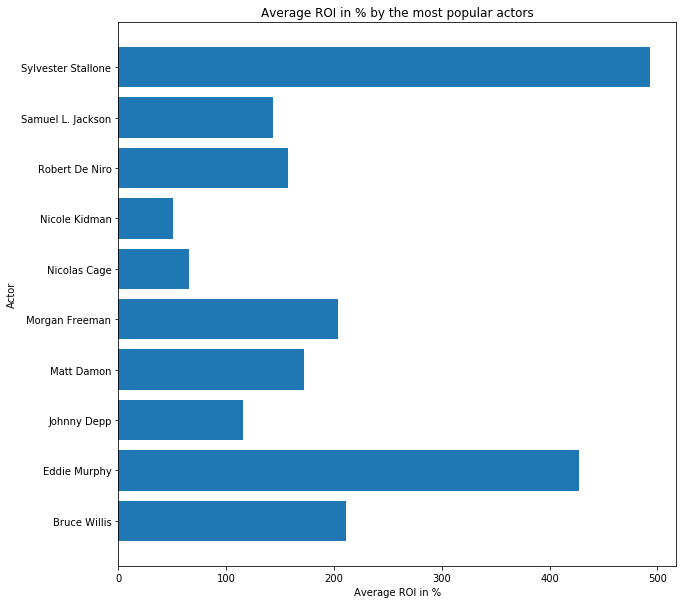

In [42]:
# Use this, and more code cells, to explore your data. Don't forget to add
#   Markdown cells to document your observations and findings.

# Filter for most frequent actors
df_most_frequent = df_actor.query('cast in {}'.format(most_frequent_actors))

# Find average ROI for each popular actor
df_mean_actor_ROI = df_most_frequent.groupby('cast')['ROI (%)'].mean()

def plot_bar(figsize_x,figsize_y,is_horizontal,ind_var,dep_var,rotation,xlabel,ylabel,title):
    """
    Function to plot bar plots
    Args:
        figsize_x     => Length of plot along x axis
        figsize_y     => Length of plot along y-axis
        is_horizontal => Whether horizontal bar plot is desired
        ind_var       => Independent variable
        dep_var       => Dependent Variable
        rotation      => Angle by which x-axis labels are to be rotated
        xlabel        => Label for x-axis
        ylabel        => Label for y-axis
        title         => title of bar plot
    Returns:
        void (Bar plot is generated for given params)
    """
    print(dep_var.describe())
    plt.figure(figsize = (figsize_x,figsize_y));
    if is_horizontal == True:
        plt.barh(ind_var, dep_var);
    else:
        plt.bar(ind_var,dep_var)
    plt.xticks(rotation = rotation);
    plt.xlabel(xlabel);
    plt.ylabel(ylabel);
    plt.title(title);

# Plot bar showing average ROI for each popular actor
plot_bar(\
         10,
         10,
         True,
         df_mean_actor_ROI.index,
         df_mean_actor_ROI,
         0,
         'Average ROI in %',
         'Actor',
         'Average ROI in % by the most popular actors')

count     10.000000
mean    -200.065879
std      145.594478
min     -353.309729
25%     -281.739204
50%     -239.337623
75%     -194.621852
max       89.127383
Name: ROI (%), dtype: float64


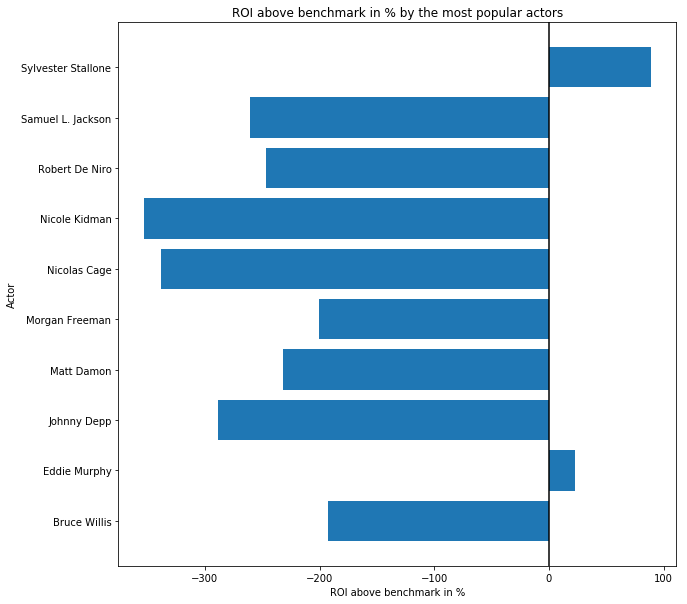

In [43]:
# Benchmark ROI for actors
mean_ROI = df_actor.groupby('cast')['ROI (%)'].mean().mean()

ROI_above_benchmark = df_mean_actor_ROI - mean_ROI

# Plot bar showing ROI above benchmark for each popular actor
plot_bar(\
         10,
         10,
         True,
         ROI_above_benchmark.index,
         ROI_above_benchmark,
         0,
         'ROI above benchmark in %',
         'Actor',
         'ROI above benchmark in % by the most popular actors')
plt.axvline(0, color='black');

#### Altered view
It appears that a majority of the popular actors do not beat the benchmark ROI of movies in the dataset. Then why are they selected in the first place?
I can think of one reason - their movies perform reliably at the box office. As a result, their fees might be substantially high driving up production costs and reducing the ROI of the movie.
We can check for actors with higher ROI and the frequency of occurence in the dataset. After all, there may be a slight chance that a lot of these actors are one-hit wonders!

#### Comparison of reliability of ROI performance between most frequent actors and benchmark reliability

In this section we will confirm that the reliability (measured by standard deviation) of performance of movies starring the most popular actors is better than the benchmark reliability. This will help us prove the first part of the altered view - "movies of popular actors perform reliably at the box office"

count      10.000000
mean     -108.445275
std       524.812988
min     -1248.640926
25%      -125.232235
50%        90.199995
75%       222.320132
max       316.991252
Name: ROI (%), dtype: float64


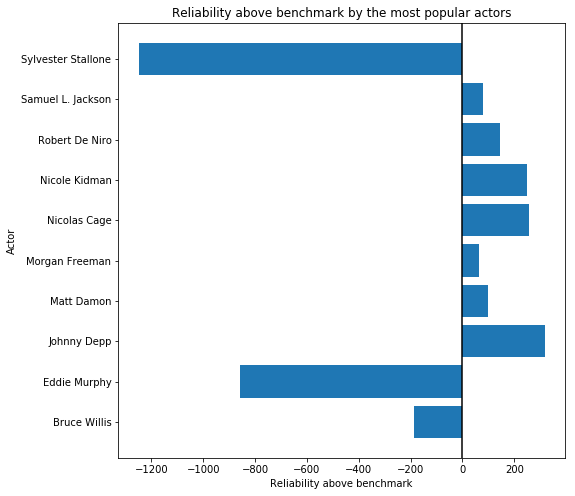

In [44]:
df_std_pop_actors = df_most_frequent.groupby('cast')['ROI (%)'].std()
df_benchmark_std = df_actor.groupby('cast')['ROI (%)'].std().mean()
df_reliability_popular = df_benchmark_std - df_std_pop_actors

# Plot bar showing Reliability above benchmark for each popular actor
plot_bar(\
 8,
 8,
 True,
 df_reliability_popular.index,
 df_reliability_popular,
 0,
 'Reliability above benchmark',
 'Actor',
 'Reliability above benchmark by the most popular actors')
plt.axvline(0, color='black');

As can be seen, the most reliable performance at box office is given by actors who have failed to beat the benchmark for ROI. In fact, the lower the ROI is from the benchmark ROI, a corresponding increase in reliability above benchmark is seen. This affirms the first part of our altered view

count    10.0
mean      1.0
std       0.0
min       1.0
25%       1.0
50%       1.0
75%       1.0
max       1.0
Name: cast, dtype: float64


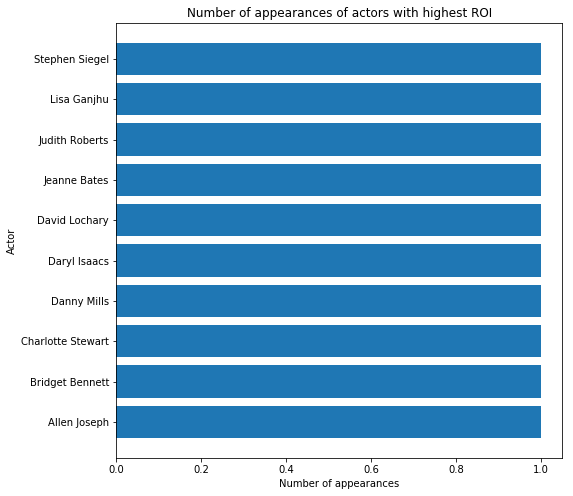

In [45]:
highest_ROI_actors = list(df_actor.groupby('cast')['ROI (%)'].mean().sort_values().tail(10).index)
df_freq_actors_ROI_high = df_actor.query('cast in {}'.format(highest_ROI_actors))['cast'].value_counts()

# Plot bar showing number of appearances of each actor having high ROI
plot_bar(\
         8,
         8,
         True,
         df_freq_actors_ROI_high.index,
         df_freq_actors_ROI_high,
         0,
         'Number of appearances',
         'Actor',
         'Number of appearances of actors with highest ROI')

### Conclusion for Question 1
Thus we can conclude that our altered hypothesis was correct. A lot of actors may have acted in a single movie that may have performed way better than the benchmark driving up the average ROI. The veteran (popular) actors however have provided consistent returns that have failed to beat the benchmark but the reliability of performance of their movies at the box office has culminated in higher frequency of appearance in movies

### 2. Most popular directors and the ROI of their movies adjusted for inflation for 2010

In this section, we will study the correlation between the directors and the ROI raked in by their movies. In particular, we will be examining if the directors that have been the most active have beaten the average benchmark ROI. 

count     10.000000
mean     345.168500
std      288.436069
min      127.670484
25%      180.864721
50%      218.840701
75%      330.670130
max      951.815663
Name: ROI (%), dtype: float64


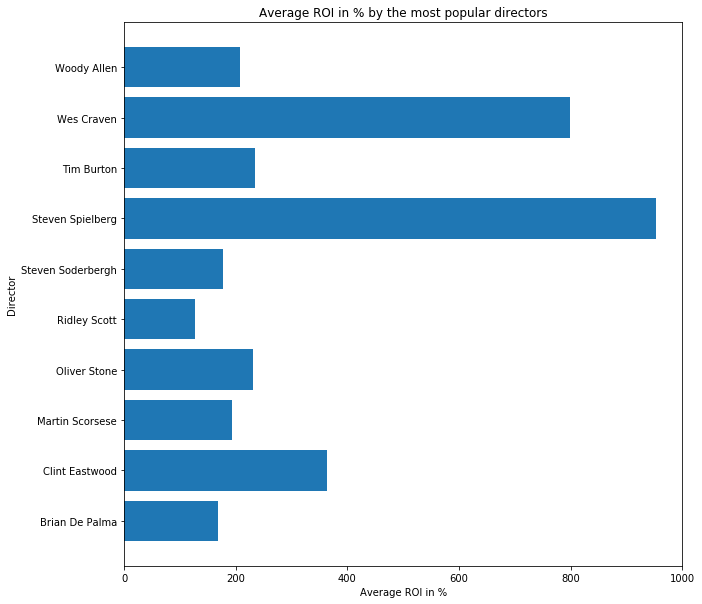

In [46]:
# Continue to explore the data to address your additional research
#   questions. Add more headers as needed if you have more questions to
#   investigate.
most_frequent_directors = list(df_movie['director'].value_counts().sort_values().tail(10).index)
df_director = df_movie.query('director in {}'.format(most_frequent_directors))
df_mean_director = df_director.groupby('director')['ROI (%)'].mean()

# Plot bar showing average ROI for each popular actor
plot_bar(\
         10,
         10,
         True,
         df_mean_director.index,
         df_mean_director,
         0,
         'Average ROI in %',
         'Director',
         'Average ROI in % by the most popular directors')

count     10.000000
mean     115.175565
std      288.436069
min     -102.322450
25%      -49.128213
50%      -11.152234
75%      100.677195
max      721.822729
Name: ROI (%), dtype: float64


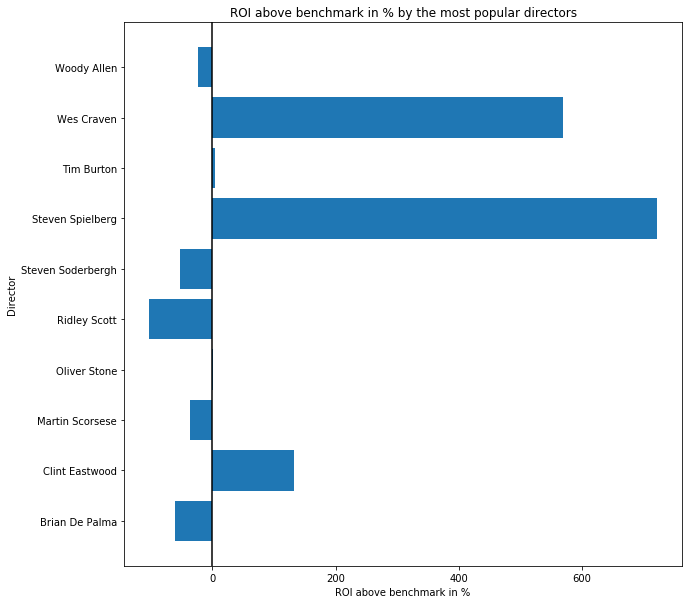

In [47]:
# Benchmark ROI for directors
mean_ROI_dir = df_movie.groupby('director')['ROI (%)'].mean().mean()

ROI_above_benchmark_dir = df_mean_director - mean_ROI_dir

# Plot bar showing ROI above benchmark for each popular actor 
plot_bar(\
         10,
         10,
         True,
         ROI_above_benchmark_dir.index,
         ROI_above_benchmark_dir,
         0,
         'ROI above benchmark in %',
         'Director',
         'ROI above benchmark in % by the most popular directors')
plt.axvline(0, color='black');

Here again, a lot of the most popular directors have failed to beat the benchmark ROI, we will now proceed to validate the directors' ROI in a similar way as we did for actors 

#### Comparison of reliability of ROI performance between most frequent directors and benchmark reliability

In this section we will confirm that the reliability (measured by standard deviation) of performance of movies with most popular directors is better than the benchmark reliability.

count      10.000000
mean     -268.054454
std       764.029800
min     -2040.346220
25%       -80.080393
50%        25.945939
75%       132.112121
max       265.925079
Name: ROI (%), dtype: float64


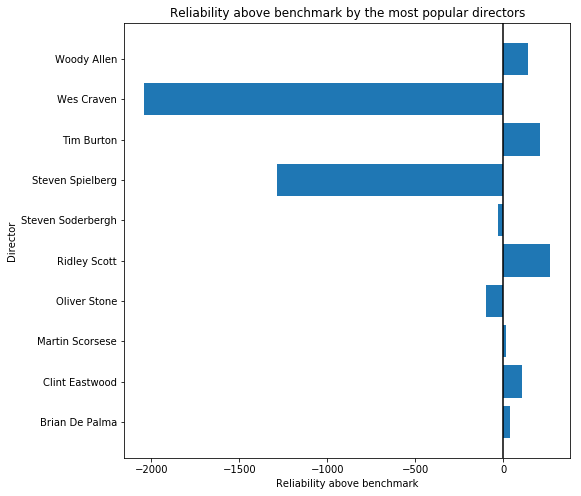

In [48]:
# Standard deviation of popular directors
df_std_pop_directors = df_director.groupby('director')['ROI (%)'].std()

# Standard deviation of all directors
df_benchmark_std_dir = df_movie.groupby('director')['ROI (%)'].std().mean()
df_reliability_popular_dir = df_benchmark_std_dir - df_std_pop_directors

# Plot bar showing Reliability above benchmark for each popular actor
plot_bar(\
         8,
         8,
         True,
         df_reliability_popular_dir.index,
         df_reliability_popular_dir,
         0,
         'Reliability above benchmark',
         'Director',
         'Reliability above benchmark by the most popular directors')
plt.axvline(0, color='black');

### Conclusion for question 2

Although in case of directors, the correlation is not as clear as in case of actors, it can be concluded that the most popular directors who have failed to beat the benchmark have made up in terms of reliability of performance of their films. This might be the reason for their popularity among producers and financers

### 3. Runtime of Movies And Its Correlation with Ratings

In this section, we will be examining the correlation between ratings and runtime of a movie. Perhaps there is an optimum runtime that maximizes ratings (ceteris paribus of course)? We can add a column for classifying movies based on length and then proceed to average ratings for these classes.

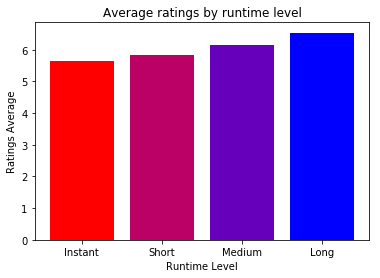

In [49]:
bin_edge = [0, 93, 103, 117, 540]
bin_names = range(0,4)
df_movie['runtime_level'] = pd.cut(df_movie['runtime'],bin_edge,labels = bin_names)
runtime_avg_ratings = df_movie.groupby('runtime_level')['vote_average'].mean()

print()

locations = np.array(runtime_avg_ratings.sort_values().index)
heights = np.array(runtime_avg_ratings.sort_values())
# Plot bar chart with ratings
plt.bar(locations, heights,color = ['#FF0000','#BB0066','#6600BB','#0000FF'], tick_label = ['Instant','Short','Medium', 'Long']);
plt.xticks(rotation = 0);
plt.xlabel('Runtime Level');
plt.ylabel('Ratings Average');
plt.title('Average ratings by runtime level');

Now that we know that the rating are in general increasing with runtime, it is time to examine the pattern in the long data set ie check if there exists any sort of maxima or minima anywhere. This would give us useful insight into what runtime is optimal for good ratings

Maximum values of ratings at: [200, 247]


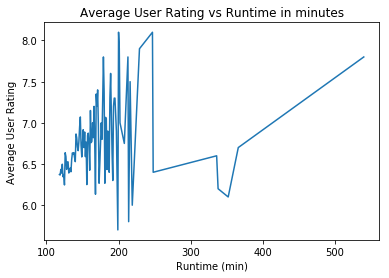

In [50]:
ratings_by_runtime = df_movie[df_movie['runtime_level']==3].groupby('runtime')['vote_average'].mean()

def plot_line(x,y,xlabel,ylabel,title):
    """
    Function to display line plot
    Args:
        x => Variable on x-axis
        y => Variable on y-axis
        xlabel => X-Axis label
        ylabel => Y-Axis label
        title => Title of line plot
    Returns:
        void (Displays line plot)
    """
    plt.plot(x, y);
    plt.xlabel(xlabel);
    plt.ylabel(ylabel);
    plt.title(title);
    
# Plot graph of user ratings by runtime
plot_line(\
         ratings_by_runtime.index,
         ratings_by_runtime,
         'Runtime (min)',
         'Average User Rating',
         'Average User Rating vs Runtime in minutes')

print("Maximum values of ratings at: {}".format(list(ratings_by_runtime[ratings_by_runtime == ratings_by_runtime.max()].index)))

### Conclusion for question 3

Thus we can see that the ratings peak at some point before dropping and beginning to rise again. Perhaps we could draw further conclusions from this behavior if we had a curve fitting technique for the data

### 4. Correlation between ratings and ROI

The relationship between the ratings and ROI should reveal yet another aspect of the data. Since user reviews are constantly being updated and what might work today might not have worked then, perhaps it would be incorrect to apply a cause-effect relationship between the two. However, the data should show some degree of positive correlation between user ratings and high.

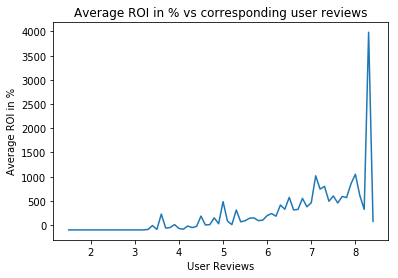

In [51]:
df_movie.groupby('vote_average')['ROI (%)'].mean()

# Plot line plot for ROI vs user reviews
plot_line(\
         df_movie.groupby('vote_average')['ROI (%)'].mean().index,
         df_movie.groupby('vote_average')['ROI (%)'].mean(),
         "User Reviews",
         "Average ROI in %",
         "Average ROI in % vs corresponding user reviews")

### Conclusion for question 4

We can see from the above graph that there is an increasing trend in ROI with increasing ratings of users. With the help of curve fitting, we would be able to better illustrate and explain the graph.  

### 5. Yearwise receptivity of different genres based on ROI

For the final question, we will generate a heatmap based on ROI with the genres and years on orthogonal axes. This should reveal yet another interesting behavior about the preferences of people in the recent (2005-2015) years.

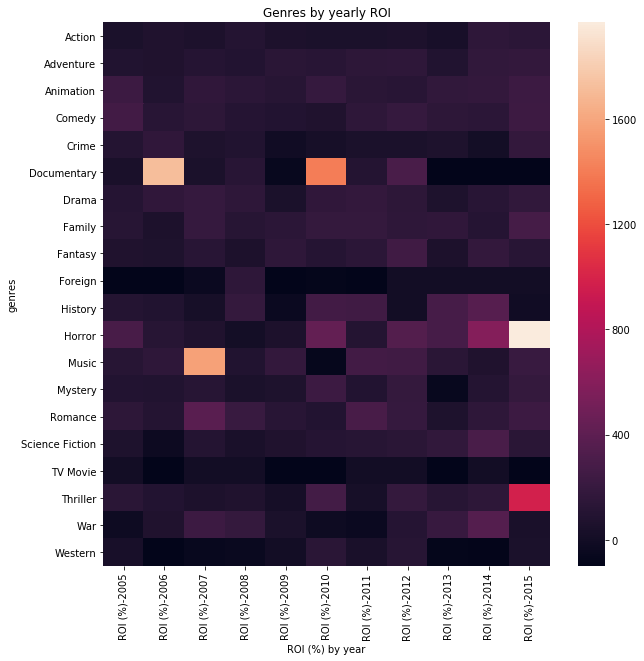

In [52]:
pvt_years_by_genres = pd.pivot_table(df_genres, values = ['ROI (%)'], index = ['genres'], columns = ['release_year'], aggfunc = np.mean)
pvt_years_by_genres.fillna(0, inplace = True)
pvt_years_by_genres

sns.color_palette("magma")
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(pvt_years_by_genres.iloc[:, 45:56]);
plt.xlabel("ROI (%) by year");
plt.title("Genres by yearly ROI");

### Conclusion for question 5
Horror and war movies have picked up quite a lot in the recent years. Genres like "Foreign","Western" and "TV movie" continue to be ill-received with intermittent periods of revival of interest. In 2006 and 2010, documentaries seem to have yielded significant ROI while in 2007, music seems to be the cash cow. However, the relationship between genres and ROI appears quite complex and there appears to be no simple recipe for commercial success of a movie

<a id='conclusions'></a>
## Conclusions

1. The most frequently casted actors appear to be those which provide a higher degree of reliability in ROI than the rest. This might come at an expense of lower mean absolute ROI than the benchmark average.
2. Most films are directed by directors with higher reliability of ROI performance than the rest sacrificing absolute ROI in the process
3. User ratings appear to cap between 200 and 247 minutes of movie runtime when not accounting for any other factors
4. ROI and ratings are positively correlated
5. The heatmap of ROI and genres across the most recent 10 years suggests that the relationship between genres and ROI may be more complex than initially thought. There may not be a standard formula for the mix of genres that provide value to all stakeholders (producers as well as consumers) of any movie.

### Limitations of Observations
1. The presence of presumably bizarre values of budget (some of which are in 100s of dollars!!) made it necessary for me to drop rows for which the ROI was insanely high. As a result, the dataset is considerably reduced (from 10,866 sample movies to 5164 sample movies) which will of course impact the universality and general applicability of the observed results.
2. With curve fitting techniques, we could take these questions even beyond their current conclusions. However, I am yet to understand how to implement these in python so that limits the observations I can make from some of the plots (this limitation is indicated wherever applicable)
3. Some of the observations (runtime and ratings correlation) hinge on the assumption that other factors are more or less the same in order to draw conclusions. This is obviously not true. Nevertheless, it is interesting to validate what follows intuitively. Hence the analysis has been included.

### Changelog (Changes from version 1 that was submitted)
1. Functions written to minimise code redundancy wherever possible (for generating bar/line plots)
2. Bar charts made horizontal in order to better represent the Actor/Director axis to make the constituents more readable
3. Descriptive statistics for each plot provided in order to augment the visuals with quantitative information
4. Limitations of observations/conclusions drawn provided in order to shed light on the applicability of the results

## Submitting your Project 

> Before you submit your project, you need to create a .html or .pdf version of this notebook in the workspace here. To do that, run the code cell below. If it worked correctly, you should get a return code of 0, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).

> Alternatively, you can download this report as .html via the **File** > **Download as** submenu, and then manually upload it into the workspace directory by clicking on the orange Jupyter icon in the upper left, then using the Upload button.

> Once you've done this, you can submit your project by clicking on the "Submit Project" button in the lower right here. This will create and submit a zip file with this .ipynb doc and the .html or .pdf version you created. Congratulations!

In [53]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Investigate_a_Dataset.ipynb'])

0